Import

In [1]:
!git clone https://github.com/AndreasHammerKU/CardiacCTAnalysis.git
%cd CardiacCTAnalysis

Cloning into 'CardiacCTAnalysis'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 58 (delta 16), reused 45 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 465.88 KiB | 8.96 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/CardiacCTAnalysis


In [5]:
from google.colab import drive
drive.mount('/content/drive')

dataset_folder = '/content/drive/MyDrive/Data'

import nibabel as nib
import json
import os

def load_nifti(file_path):
    nii_img = nib.load(file_path)
    affine = nii_img.affine  # Get transformation matrix
    return nii_img.get_fdata(), affine

def load_data(image_name):
    # Load NIfTI file
    nifti_path = os.path.join(dataset_folder, 'images', image_name + '.nii.gz')
    nifti_data, affine = load_nifti(nifti_path)

    # Check scanner orientation

    # Load landmark JSON
    with open(os.path.join(dataset_folder, 'landmarks', image_name + '.json')) as file:
        landmark_data = json.load(file)

    return nifti_data, affine, landmark_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import utils.geometry_fitting as geom


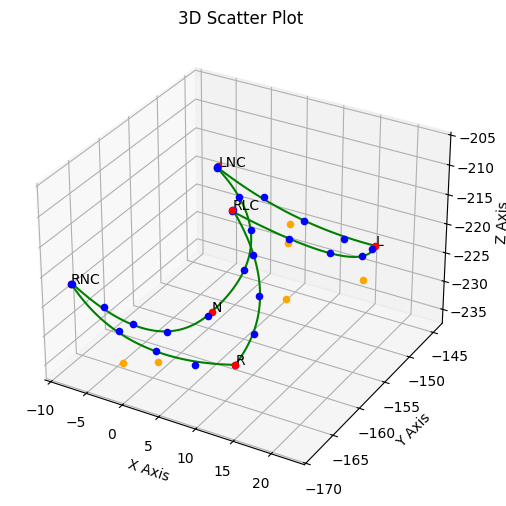

In [7]:
_, affine, landmarks = load_data('n1')

geometry = geom.LeafletGeometry(landmarks)
geometry.calculate_bezier_curves()
geometry.plot(plot_label_points=True, plot_control_points=True)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from scipy.special import binom
from collections import deque

# Function to compute Bézier curve points given control points
def bezier_curve(p0, p1, p2, num_points=10):
    t = np.linspace(0, 1, num_points)
    curve = np.outer((1 - t) ** 2, p0) + np.outer(2 * (1 - t) * t, p1) + np.outer(t ** 2, p2)
    return curve.astype(int)  # Convert to integer indices for accessing grid values

# Define a 3D environment for the agent
class Bezier3DEnv:
    def __init__(self, grid, p0, p2, ground_truth):
        self.grid = grid  # 3D numpy array (image)
        self.p0 = np.array(p0)  # Start point of Bézier curve
        self.p2 = np.array(p2)  # End point of Bézier curve
        self.ground_truth = np.array(ground_truth)  # True control point
        self.state = (self.p0 + self.p2) // 2  # Start in the midpoint
        self.actions = [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]  # Move in 6 directions

    def reset(self):
        self.state = (self.p0 + self.p2) // 2  # Reset to midpoint
        return self.state

    def step(self, action):
        new_state = np.clip(self.state + np.array(action), [0, 0, 0], np.array(self.grid.shape) - 1)
        curve_points = bezier_curve(self.p0, new_state, self.p2)  # Compute Bézier curve
        gradient = np.gradient(self.grid)  # Compute gradients in 3D space

        # Compute reward: sum of gradient magnitudes along the curve
        reward = np.sum([np.linalg.norm([g[tuple(pt)] for g in gradient]) for pt in curve_points])

        self.state = new_state
        done = np.array_equal(self.state, self.ground_truth)  # Stop if agent reaches the ground truth control point
        return self.state, reward, done

# Define a simple Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
# Hyperparameters
gamma = 0.9  # Discount factor
lr = 0.01  # Learning rate
epsilon = 0.1  # Exploration rate
episodes = 500
batch_size = 16
memory = deque(maxlen=1000)

In [10]:
# Setup environment and model
grid = np.random.rand(10, 10, 10)  # Example 3D image
p0, p2 = (2, 2, 2), (7, 7, 7)  # Endpoints of Bézier curve
ground_truth = (5, 5, 5)  # True control point
env = Bezier3DEnv(grid, p0, p2, ground_truth)

state_size = 3
action_size = len(env.actions)
model = QNetwork(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [13]:
# Training loop
for episode in range(episodes):
    state = env.reset()
    state = state = torch.tensor(state, dtype=torch.float32, requires_grad=True)
    done = False
    while not done:
        # Choose action (epsilon-greedy)
        if random.random() < epsilon:
            action = random.choice(env.actions)
        else:
            with torch.no_grad():
                q_values = model(state)
                action = env.actions[torch.argmax(q_values).item()]

        # Take step in environment
        next_state, reward, done = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32)

        # Store in replay memory
        memory.append((state, action, reward, next_state, done))
        state = next_state

        # Train on batch
        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.stack(states)
            next_states = torch.stack(next_states)
            actions = torch.tensor([env.actions.index(a) for a in actions])
            rewards = torch.tensor(rewards, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)

            # Compute target Q values
            with torch.no_grad():
                next_q_values = model(next_states)
                max_next_q_values = torch.max(next_q_values, dim=1)[0]
                targets = rewards + gamma * max_next_q_values * (1 - dones)

            # Compute loss using ground truth
            true_control = torch.tensor(ground_truth, dtype=torch.float32)
            loss = loss_fn(states, true_control)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % 50 == 0:
        print(f"Episode {episode}: Loss {loss.item():.4f}")

print("Training complete!")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn